# Mechanistic and causal models in clinical trials 

Arman Eshaghi, June 2018

Queen Square Multiple Sclerosis Centre

University College London

UK

This document aims to demonstrate codes that reproduce the results of the manuscript entitled **Applying causal models to understand the mechanism of action of simvastatin** 

We will simulate **fake data** that will produce similar (but not identical) results to the real data reported in our manuscript. The information is shared by covariance matrices and simulation methods in R. In some instances the results from original data is differnt from here,  because of slighlty different distribution of variables in our real data. This document is intended to help other researchers to use our methods in their own data.

I am working to improve our simulation approaches.

In [1]:
require(MASS)

Loading required package: MASS


#### Covariance matrix

Covariance matrices allow reproduction of many of the reported tests (at the group level) for population of patients without exposing indiviual patients' data. However, note that there are strong assumptions regarding multivariate-normality of data when covariance matrices are later used to simulate **fake data**, that is almost never strictly true in the real data. For this reason many of the results are not identical to what is reported in the manuscript, especially in the mediaton analyses reported below.


In [212]:

cov_mat <- matrix(c( 0.31186188,0.5024700,0.03845738,-0.29656497,-1.034716, 
                     0.50247004,108.3970770,0.67926848,1.65577687,1.673910, 
                     0.03845738,0.6792685,0.30155651,-0.03199188,-1.173613, 
                     -0.29656497,1.6557769,-0.03199188,1.57605450,3.442583, 
                     -1.03471645,1.6739098,-1.17361292,3.44258328,36.972688) ,  
            nrow = 5, 
            ncol = 5)

In [213]:
require(MASS)

In [191]:
## looking at the rate of change (year 2 - baseline divided by 2 ), as follows:

#EDSS: Expanded Disability Status Scale
#MSIS: Multiple Sclerosis Impact Scale (only physical subscore is used here, see paper for details)
#Cholesterol: Serum total cholesterol level
#PBVC: percentage brain volume change calculated with a mehod called SIENA
#Block design: a test of spatial cognition

id.names =c ("EDSS", "MSIS", "Cholesterol", "PBVC", "Block_Design")


In [192]:
#as reported in the manuscript, means are 

mu_placebo <- c(0.43, 4.3, -0.0043, -1.4221, -0.5348) 
mu_treatment <- c(0.1818182, 1.017859, -0.7429688, -0.9158269, 1.422222)

We will use multivariate normal distribution to simulate data, although this will not produce the exact same distributions, this is sufficient to reproduce the results.

In [214]:
placebo_var <- mvrnorm(n=64, mu=mu_placebo, Sigma=cov_mat, empirical = TRUE )
treatment_var <- mvrnorm(n=67, mu = mu_treatment, Sigma = cov_mat, empirical = TRUE )

In [215]:
placebo_df <- data.frame(placebo_var)

In [216]:
placebo_df$treatment <- 'placebo'

In [217]:
treatment_df <- data.frame(treatment_var)

In [218]:
treatment_df$treatment <- 'treatment'

In [219]:
df <- rbind(placebo_df, treatment_df)

In [220]:
colnames(df) <- c(id.names, 'group') 

#### Figure 2: showing the scatterplots of simulated (fake) data

In [223]:
require(ggplot2)
require(gridExtra)

In [224]:
p <- ggplot(df, aes(group, EDSS) )
p <- p + #geom_boxplot(outlier.shape= NA) + 
    stat_summary(fun.y = median, fun.ymin = median, fun.ymax = median,
                 geom = "crossbar", 
                 width = 0.8 ) + geom_jitter(aes(colour = group), width = 0.3, 
                                             height = 0.1, alpha = 5/10) + theme_bw() + 
 ylab('EDSS') +  theme(legend.position="none") 
edss_p <- p

p <- ggplot(df, aes(group, MSIS) )
p <- p + #geom_boxplot(outlier.shape= NA) + 
    stat_summary(fun.y = median, fun.ymin = median, fun.ymax = median,
                 geom = "crossbar", 
                 width = 0.8 ) + geom_jitter(aes(colour = group), width = 0.3, alpha = 5/10
                                            ) + theme_bw()   + ylab('MSIS') +   
theme(legend.position="none")  
msis_p <- p

p <- ggplot(df, aes(group, Block_Design) )
p <- p + # geom_boxplot(outlier.shape= NA) + 

stat_summary(fun.y = median, fun.ymin = median, fun.ymax = median,
                 geom = "crossbar", 
                 width = 0.8 ) +geom_jitter(aes(colour = group), width = 0.3, alpha = 5/10) +
theme_bw() + ylab(' Block Design') +  theme(legend.position="none") 
block_p <- p 


p <- ggplot(df, aes(group,PBVC) )
p <- p + #geom_boxplot(outlier.shape= NA) + 
      stat_summary(fun.y = median, fun.ymin = median, fun.ymax = median,
                 geom = "crossbar", 
                 width = 0.8 ) + geom_jitter(aes(colour = group), width = 0.3,  alpha = 5/10) + theme_bw()  +
 ylab('PBVC') +  theme(legend.position="none") 
pbvc_p <- p 




p <- ggplot(df, aes(group, Cholesterol) )
p <- p + #geom_boxplot(outlier.shape= NA) + 
 
      stat_summary(fun.y = median, fun.ymin = median, fun.ymax = median,
                 geom = "crossbar", 
                 width = 0.8 ) + geom_jitter(aes(colour = group), width = 0.3, 
                                             alpha = 5/10) + theme_bw()  + 
ylab('Cholesterol') +  theme(legend.position="none") 

cholesterol_p <- p 



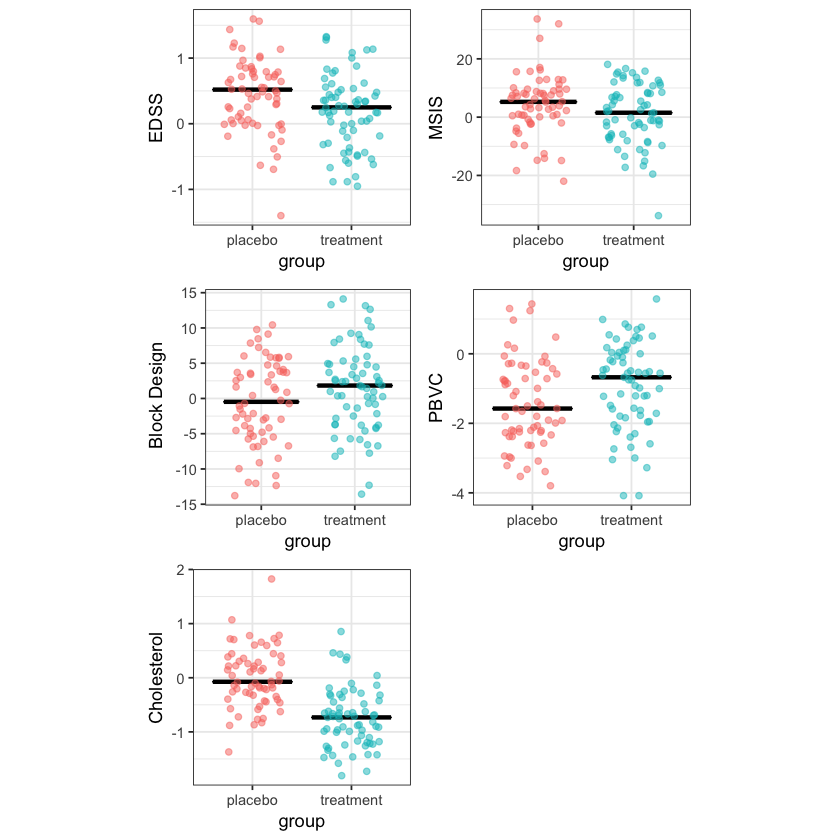

In [225]:
p <- grid.arrange(edss_p, msis_p, block_p, pbvc_p , cholesterol_p, ncol = 2, nrow = 3, respect=TRUE)



###### The plots looks similar to what is reported. 

----

Structural equation models

In [226]:
require(lavaan)

In [227]:
colnames( df )

[1] "EDSS"         "MSIS"         "Cholesterol"  "PBVC"         "Block_Design"
[6] "group"

See Figure 3 of the paper for explanation of model B

In [229]:
model_B <- '#Atrophy & Cholesterol mediation model
Cholesterol ~ a*group
PBVC ~ b*group
EDSS ~ d*PBVC
EDSS ~ e*group
Block_Design ~ f*PBVC
Block_Design ~ g*group
MSIS ~ h*PBVC
MSIS ~ i*EDSS
MSIS ~ k*Block_Design
MSIS ~ l*group

#covariance matrices
Cholesterol ~~ Cholesterol
PBVC ~~ PBVC
EDSS ~~ EDSS
Block_Design ~~ Block_Design
MSIS ~~ MSIS
'

In [230]:
df$group <- factor(df$group)

In [246]:
B <- sem(model_B,  data=df,
                missing="FIML", fit.measures = T, standardized = T , rsquare = T)



In [247]:
summary(B, fit.measures = T, standardized = T , rsquare = T)

lavaan (0.5-23.1097) converged normally after  84 iterations

  Number of observations                           131

  Number of missing patterns                         1

  Estimator                                         ML
  Minimum Function Test Statistic               22.929
  Degrees of freedom                                 4
  P-value (Chi-square)                           0.000

Model test baseline model:

  Minimum Function Test Statistic              153.435
  Degrees of freedom                                15
  P-value                                        0.000

User model versus baseline model:

  Comparative Fit Index (CFI)                    0.863
  Tucker-Lewis Index (TLI)                       0.487

Loglikelihood and Information Criteria:

  Loglikelihood user model (H0)              -1406.430
  Loglikelihood unrestricted model (H1)      -1394.966

  Number of free parameters                         21
  Akaike (AIC)                                2854.861
  B

### Example of frequentist and Bayesian mediation models

In [248]:
med_chol_edss <- '#Atrophy & Cholesterol mediation model
Cholesterol ~ b1*group
EDSS ~ b2*Cholesterol
EDSS ~ c*group
#co / variance matrices
Cholesterol ~~ Cholesterol
EDSS ~~ EDSS 
# direct and indirect effects
ind := ( b1 * b2 )
totl := c + ( b1 * b2 )'


In [249]:
edss_chol <- sem(med_chol_edss, data=df,
                 
                missing="FIML", fit.measures = T, std.lv=TRUE                  
)

In [250]:
summary(edss_chol)

lavaan (0.5-23.1097) converged normally after  19 iterations

  Number of observations                           131

  Number of missing patterns                         1

  Estimator                                         ML
  Minimum Function Test Statistic                0.000
  Degrees of freedom                                 0

Parameter Estimates:

  Information                                 Observed
  Standard Errors                             Standard

Regressions:
                   Estimate  Std.Err  z-value  P(>|z|)
  Cholesterol ~                                       
    group     (b1)   -0.739    0.095   -7.755    0.000
  EDSS ~                                              
    Cholestrl (b2)    0.128    0.088    1.447    0.148
    group      (c)   -0.154    0.116   -1.327    0.185

Intercepts:
                   Estimate  Std.Err  z-value  P(>|z|)
   .Cholesterol       0.734    0.152    4.843    0.000
   .EDSS              0.585    0.166    3.519    0.000

Varia

This model can be done using blavaan package using a similar syntax (not shown here).

#### Atrophy mediation model

In [255]:
med_chol_atrophy <- '#Atrophy & Cholesterol mediation model
Cholesterol ~ b1*group
PBVC ~ b2*Cholesterol
PBVC ~ c*group
#covariance matrices
Cholesterol ~~ Cholesterol
PBVC ~~ PBVC
EDSS ~~ EDSS 
# direct and indirect effects
ind := ( b1 * b2 )
totl := c + ( b1 * b2 )'

In [256]:
chol_atrophy <- sem(med_chol_atrophy, data=df,
                 
                missing="FIML", fit.measures = T, std.lv=TRUE                  
)

In [257]:
summary(chol_atrophy)

lavaan (0.5-23.1097) converged normally after  28 iterations

  Number of observations                           131

  Number of missing patterns                         1

  Estimator                                         ML
  Minimum Function Test Statistic               34.035
  Degrees of freedom                                 3
  P-value (Chi-square)                           0.000

Parameter Estimates:

  Information                                 Observed
  Standard Errors                             Standard

Regressions:
                   Estimate  Std.Err  z-value  P(>|z|)
  Cholesterol ~                                       
    group     (b1)   -0.739    0.095   -7.755    0.000
  PBVC ~                                              
    Cholestrl (b2)   -0.106    0.200   -0.532    0.595
    group      (c)    0.428    0.263    1.629    0.103

Intercepts:
                   Estimate  Std.Err  z-value  P(>|z|)
   .Cholesterol       0.734    0.152    4.843    0.000
   .PB

Bayesian version of the same model

In [269]:
require(blavaan)

Loading required package: blavaan
Loading required package: runjags

Attaching package: ‘runjags’

The following object is masked from ‘package:magrittr’:

    extract

This is blavaan 0.3-2.283
blavaan is more BETA than lavaan!


In [270]:
ch_atrophy_bayesian <- bsem(med_chol_atrophy,
                data=df,
                missing="FIML", fit.measures = T, std.lv=TRUE                  
)



Warning message in blavaan(med_chol_atrophy, data = df, missing = "FIML", fit.measures = T, :
“blavaan WARNING: the following arguments have no effect:
                   missing”Loading required namespace: rjags


Compiling rjags model...
Calling the simulation using the rjags method...
Adapting the model for 1000 iterations...
Burning in the model for 4000 iterations...
Running the model for 10000 iterations...
Simulation complete


Warning message in as.POSIXlt.POSIXct(x, tz):
“unknown timezone 'zone/tz/2018c.1.0/zoneinfo/Europe/London'”

Calculating summary statistics...
Note: The monitored variables 'psi[3,3,1]' and 'alpha[3,1,1]' appear to
be non-stochastic; they will not be included in the convergence
diagnostic
Calculating the Gelman-Rubin statistic for 13 variables....
Finished running the simulation
Computing posterior predictives...


In [272]:
summary(ch_atrophy_bayesian)

blavaan (0.3-2.283) results of 10000 samples after 5000 adapt/burnin iterations

  Number of observations                           131

  Number of missing patterns                         1

  Statistic                                 MargLogLik         PPP
  Value                                       -474.439       0.000

Parameter Estimates:


Regressions:
                   Estimate  Post.SD  HPD.025  HPD.975     PSRF    Prior     
  Cholesterol ~                                                              
    group     (b1)   -0.738    0.097   -0.926   -0.548    1.001 dnorm(0,1e-2)
  PBVC ~                                                                     
    Cholestrl (b2)   -0.104    0.203   -0.501    0.297    1.000 dnorm(0,1e-2)
    group      (c)    0.432    0.270   -0.103    0.957    1.001 dnorm(0,1e-2)

Intercepts:
                   Estimate  Post.SD  HPD.025  HPD.975     PSRF    Prior     
   .Cholesterol       0.733    0.155    0.428    1.035    1.001 dnorm(0,1e-3)

Posterior estimates are very similar to the frequentist approach.

In [273]:
samples<- blavInspect( ch_atrophy_bayesian , 'samples')

#beta one is the firs regeression coefficient in the model syntax

b1 <- as.numeric(  samples[[1]][,1] ) 
b2 <- as.numeric( samples[[1]][,2])
c <- as.numeric( samples[[1]][,3])



ind <- as.numeric( samples[[1]][,10]) 



total <- as.numeric( samples[[1]][,11]) 


In [274]:
direct_indirect_samples <- data.frame( c(c, ind) )

direct_indirect_samples$effect <- c( rep('direct', length(c)), rep('indirect', length(ind)) )

colnames(direct_indirect_samples) <- c( 'sample', 'effect')

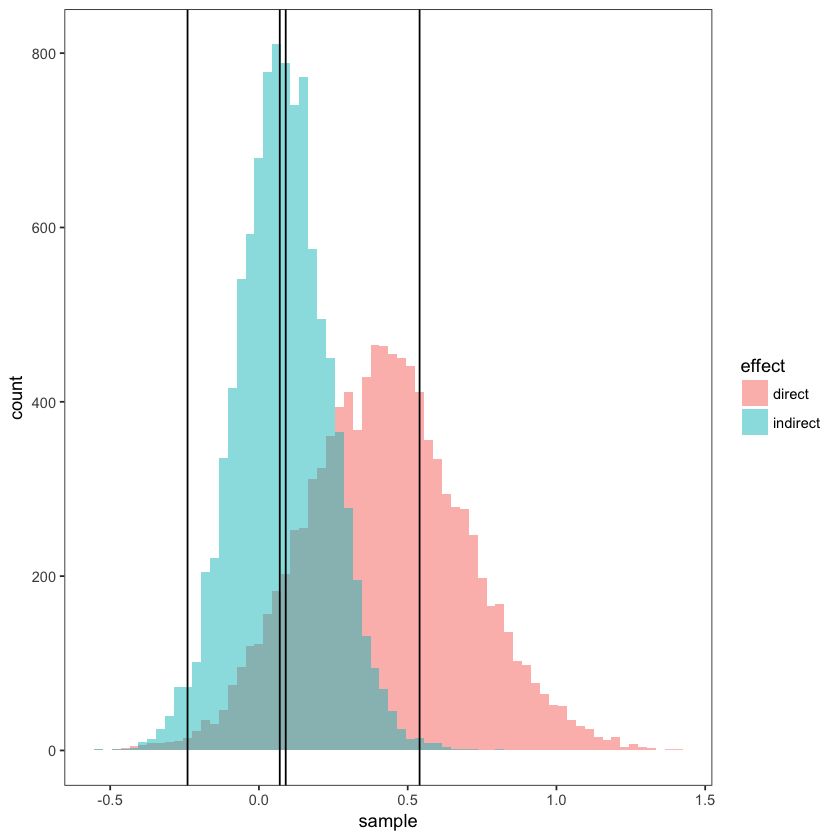

In [275]:
 p <- ggplot(direct_indirect_samples, aes(x=sample, fill=effect)) +
    geom_histogram(binwidth=.03, alpha=.5, position="identity") + theme_bw() +
#vertical lines for the original data
geom_vline(xintercept=c(-0.24, 0.07, 0.09, 0.54)) +  theme(panel.grid.major = element_blank(),
                                                           panel.grid.minor = element_blank())
p

There is an overlap between two distributions in the simulated data. Using the original data the two distributions are separate (in the 95% credible interval). Vertical lines show the distribution in the original dataset that is reported.

WIP: A non-parametric simulation approach will be introduced in near future to replicate the exact result of the manuscript.

In [263]:
med_atrophy_EDSS <- '#regression models
PBVC ~ b1*group
EDSS ~ b2*PBVC
EDSS ~ c*group

#variance and covariacne matrices
EDSS ~~ EDSS
PBVC ~~ PBVC
ind := b1 * b2
total := c + ( b1*b2)'


In [264]:
edss_atrophy <- sem(med_atrophy_EDSS, data=df,
                 
                missing="FIML", fit.measures = T, std.lv=TRUE                  
)

In [265]:
summary(edss_atrophy)

lavaan (0.5-23.1097) converged normally after  23 iterations

  Number of observations                           131

  Number of missing patterns                         1

  Estimator                                         ML
  Minimum Function Test Statistic                0.000
  Degrees of freedom                                 0
  Minimum Function Value               0.0000000000000

Parameter Estimates:

  Information                                 Observed
  Standard Errors                             Standard

Regressions:
                   Estimate  Std.Err  z-value  P(>|z|)
  PBVC ~                                              
    group     (b1)    0.506    0.218    2.325    0.020
  EDSS ~                                              
    PBVC      (b2)   -0.188    0.035   -5.343    0.000
    group      (c)   -0.153    0.090   -1.707    0.088

Intercepts:
                   Estimate  Std.Err  z-value  P(>|z|)
   .PBVC             -1.928    0.347   -5.563    0.000
   .ED

In [277]:
#percentage simvastatin effect transmitted by atrophy

(0.095/0.248) * 100

[1] 38.30645